# Linear classification for AU synthetic samples

In [1]:
# install dependencies
import sys
!{sys.executable} -m pip install xarray geopandas matplotlib sklearn --upgrade > /dev/null

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd

In [3]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# define Pandas display settings
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Define parameters

## Load composite dataset from NetCDF file

In [6]:
# open GEE image and mask water
image = xr.open_dataset('data/image.30m.nc')
image = image.where(image.FNF==1, np.nan)
del image['DSM']
del image['FNF']
image

<xarray.Dataset>
Dimensions:        (x: 1866, y: 1483)
Coordinates:
  * x              (x) float64 116.8 116.8 116.8 116.8 ... 117.3 117.3 117.3
  * y              (y) float64 -9.031 -9.031 -9.031 ... -8.633 -8.633 -8.632
Data variables: (12/25)
    S2SRB1         (y, x) float32 0.0178 0.0178 0.0183 ... 0.0172 0.0175 0.0175
    S2SRB2         (y, x) float32 0.0238 0.0218 0.0225 ... 0.0182 0.0217 0.0198
    S2SRB3         (y, x) float32 0.0453 0.0435 0.0424 ... 0.0292 0.0372 0.0329
    S2SRB4         (y, x) float32 0.0286 0.027 0.0291 ... 0.0172 0.0227 0.0188
    S2SRB5         (y, x) float32 0.0887 0.0854 0.0793 ... 0.0504 0.0616 0.0593
    S2SRB6         (y, x) float32 0.2497 0.2379 0.2279 ... 0.15 0.1807 0.1901
    ...             ...
    LC8TOAB8       (y, x) float32 0.0 0.0 0.0 0.0 ... 0.05459 0.0571 0.05543
    LC8TOAB9       (y, x) float32 0.0 0.0 0.0 0.0 ... 0.001056 0.001009 0.00102
    LC8TOAB10      (y, x) float32 0.0 0.0 0.0 0.0 ... 295.3 295.3 295.3 295.2
    LC8TOAB11      (y, x) float32 0.0 0.0 0.0 0.0 ... 293.4 293.3 293.3 293.3
    topoDiversity  (y, x) float32 0.349 0.349 0.349 ... 0.6316 0.6316 0.6316
    mTPI           (y, x) float64 -7.0 -7.0 -7.0 -7.0 ... -34.0 -34.0 -34.0

## Load synthetic samples from file

In [7]:
samples = gpd.read_file(f'samples_synthetic_3class.geojson')

In [8]:
dasamples = image.sel(x=xr.DataArray(samples.geometry.x), y=xr.DataArray(samples.geometry.y), method='nearest')
for band in image.data_vars:
    samples[band] = dasamples[band]
# add raster coordinates
samples['latitude'] = dasamples.y
samples['longitude'] = dasamples.x

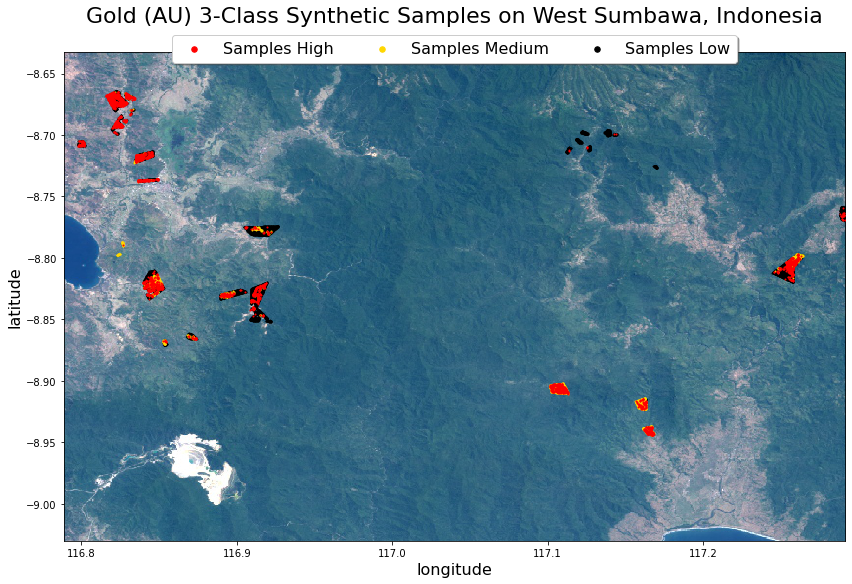

In [9]:
plt.figure(figsize=(14,9))
ax = plt.gca()
# show basemap
preview = xr.open_rasterio('data/preview.800x800.jpg')
preview.plot.imshow(ax=ax, alpha=1, zorder=-1)
preview.close()
samples[samples['class']==2].plot.scatter(ax=ax, x='longitude', y='latitude', c='red', s=1,
                                          label=f'Samples High', zorder=102)
samples[samples['class']==1].plot.scatter(ax=ax, x='longitude', y='latitude', c='gold', s=1,
                                          label=f'Samples Medium', zorder=101)
samples[samples['class']==0].plot.scatter(ax=ax, x='longitude', y='latitude', c='black', s=1,
                                          label=f'Samples Low',    zorder=100)
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=16)# increase legend marker size
for handle in legend.legendHandles:
    handle._sizes = [30]
# increase labels
for _ in [ax.xaxis, ax.yaxis]:
    _.label.set_size(16)
# tune map extent
plt.ylim([-9.03, None])
title = 'Gold (AU) 3-Class Synthetic Samples on West Sumbawa, Indonesia'
plt.title(f'{title}\n', fontsize=22)
plt.savefig(f'{title}.jpg', dpi=150)
plt.show()

## Classification

In [10]:
X = samples[image.data_vars]
y = samples['class']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=42)

### Parameter optimizing

In [11]:
scores = {}
for C in np.logspace(-2, 7, 10):
    estimator = LinearSVC(random_state=0, C=C)
    with ignore_warnings(category=ConvergenceWarning):
        estimator.fit(X_train, y_train)
    score = np.round(estimator.score(X_test, y_test),3)
    scores[C] = score
    print (C, score)
# find C for maximum score above
Cmax = max(scores, key=scores.get)
print ('max score:')
print (Cmax, scores[Cmax])

0.01 0.931
0.1 0.959
1.0 0.964
10.0 0.961
100.0 0.939
1000.0 0.919
10000.0 0.9
100000.0 0.9
1000000.0 0.929
10000000.0 0.929
max score:
1.0 0.964


### Dataset processing

In [12]:
estimator = LinearSVC(random_state=0, C=Cmax)
with ignore_warnings(category=ConvergenceWarning):
    estimator.fit(X_train, y_train)
points = image.isel(x=slice(1,-1), y=slice(1,-1)).to_dataframe().dropna()
X_points = StandardScaler().fit_transform(points.values)
prediction = estimator.predict(X_points)
print ('Average class value', prediction.mean(), 'Unique classes', np.unique(prediction))

Average class value 0.5667393671305161 Unique classes [0 1 2]


In [13]:
mask = pd.DataFrame(prediction, index=points.index).reset_index().rename(columns={0:'class'})
# check items per class
mask[['class','x']].groupby('class').count()/1e6

,x
class,
0,1.449216
1,0.460936
2,0.433712


### Plot prediction

In [ ]:
plt.figure(figsize=(14,9))
ax = plt.gca()
# show basemap
preview = xr.open_rasterio('data/preview.800x800.jpg')
preview.plot.imshow(ax=ax, alpha=1, zorder=-1)
preview.close()
mask[mask['class'] == 2].plot.scatter(ax=ax, x='x', y='y',
    c='#F5B041', s=1, alpha=0.4, label=f'Prediction High', zorder=2)
mask[mask['class'] == 1].plot.scatter(ax=ax, x='x', y='y',
    c='#F9E79F', s=0.1, alpha=0.4, label=f'Prediction Medium', zorder=1)
samples[samples['class']==2].plot.scatter(ax=ax, x='longitude', y='latitude', c='red', s=.1,
                                      label=f'Samples High', zorder=102)
samples[samples['class']==0].plot.scatter(ax=ax, x='longitude', y='latitude', c='black', s=.1,
                                          label=f'Samples Low',    zorder=100)
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize=16)
# increase legend marker size
for handle in legend.legendHandles:
    handle._sizes = [30]
# increase labels
for _ in [ax.xaxis, ax.yaxis]:
    _.label.set_size(16)
# tune map extent
plt.ylim([-9.03, None])
title = 'Gold (AU) 3-Class Prediction Synthetic on West Sumbawa, Indonesia'
plt.title(f'{title}\n', fontsize=22)
plt.savefig(f'{title}.jpg', dpi=150)
plt.show()